In [1]:
from google.colab import drive
import sys

drive.mount('/content/drive')

FOLDERNAME = '682_Project'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/682_Project


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import string
import math
import cv2

import numpy as np
import h5py

%load_ext autoreload
%autoreload 2

import flickr

In [ ]:
# !pip install xlsxwriter
# import xlsxwriter

## Data Loading

In [3]:
imags_folder_path = './Flickr8k_Dataset/Flicker8k_Dataset'
all_captions = './Flickr8k_text/Flickr8k.token.txt'
train_img_names_file = './Flickr8k_text/Flickr_8k.trainImages.txt'
test_img_names_file = './Flickr8k_text/Flickr_8k.testImages.txt'
dev_img_names_file = './Flickr8k_text/Flickr_8k.devImages.txt'

#### Some useful functions

In [4]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    print(file)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc =  " ".join(image_caption) 
            descriptions[image].append(desc)

    return descriptions

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

# getting all the image captions
captions = all_img_captions(all_captions)

# getting clean captions
cleaned_captions = cleaning_text(captions)

#saving each description to file 
save_descriptions(cleaned_captions, "descriptions.txt")

#### Loading test images

We will load all the captions and then we can use to get caption for different datasets. 

In [ ]:
test_imgs = load_photos(test_img_names_file)
train_imgs = load_photos(train_img_names_file)
dev_imgs = load_photos(dev_img_names_file)
all_captions = load_clean_descriptions("descriptions.txt", test_imgs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print('Number of train images: {}'.format(len(train_imgs)))
print('Number of test images: {}'.format(len(test_imgs)))

Number of train images: 6000
Number of test images: 1000


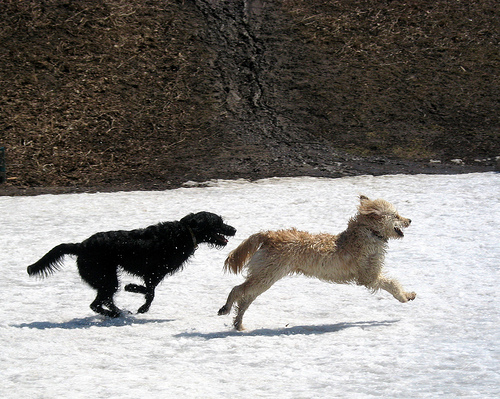

In [ ]:
Image.open(os.path.join(imags_folder_path, train_imgs[0]))

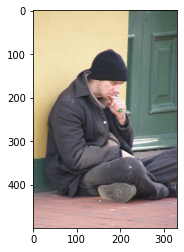

In [22]:
zz = plt.imread('/content/drive/MyDrive/682_Project/Flickr8k_Dataset/Flicker8k_Dataset/2218609886_892dcd6915.jpg')
plt.imshow(zz)

### Dataset class


In [ ]:
data = flickr.flickr_dataset(all_captions, test_imgs)

In [ ]:
dataloader = DataLoader(data, batch_size=3, shuffle=True)

### Dataloader class

In [ ]:
from torch.functional import cartesian_prod
# Training loop/ Testing loop
for i, data in enumerate(dataloader):
    images, captions = data
    print(len(images))
    for caption in captions:
      print(caption)
    print('iteration ', i, data)
    break

3
('brown and black dog on leash is sniffed by black and white dog', 'couple walking down the street carrying bags', 'pale colored dog runs through body of water')
('dog on leash walks on the sidewalk while another dog follows', 'man and woman are carrying bags down an empty street', 'white dog is running through the water at beach')
('small dog on leash is being smelled by another animal', 'man and woman walking down street carrying luggage', 'white dog is running through the water onto the shore')
('the black and white dog is sniffing the butt of the brown dog that is on leash', 'two people carrying various items walking down city street', 'the white dog runs through the ocean')
('two small dogs one blackandwhite and one brownandblack walk down the street', 'two people carry their bags down an unpaved road', 'white medium sized dog is running through the ocean')
iteration  0 [('909808296_23c427022d.jpg', '435827376_4384c3005a.jpg', '2938747424_64e64784f0.jpg'), [('brown and black dog

In [ ]:
# next(iter(dataloader))

### Feature Extraction

In [ ]:
from resnet50_features import *
from tqdm import tqdm
import pandas as pd

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Initialize ResNet50Features model to extract features of a batch of images.
model = ResNet50Features()

In [ ]:
# Load images and preprocess them into tensors
input_images = train_imgs
features = []
input_tensors = []
# outfile = 'processed_files/train_features.xlsx'
# workbook = xlsxwriter.Workbook(os.path.join(os.getcwd(), outfile))
# worksheet = workbook.add_worksheet()

# Define preprocess steps:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def prepare_input_from_files(file):
  img_path = os.path.join(imags_folder_path, file)
  img = Image.open(img_path)
  img_tensor = preprocess(img)
  return img_tensor


result = 0

def feature_extraction(dataset, batch_size):
  start = 0
  number_of_batches = math.ceil(len(dataset) / batch_size)
  result = None

  for i in tqdm(range(number_of_batches)):
    files = dataset[start : min(start + batch_size, len(dataset))]
    inputs_batch = [prepare_input_from_files(f) for f in files]
    inputs = torch.stack(inputs_batch)

    # Feature extraction
    outputs = model(inputs)

    # Flatten output tensors - [batch_size, F]
    outputs = torch.flatten(outputs, start_dim=1)

    # Convert tensors to numpy
    features = outputs.detach().cpu().numpy()
    features = features.squeeze()
    print(features.shape)

    # Concatenate features matrix together
    result = features if result is None else np.concatenate((result, features))

    start += batch_size

    del inputs

  return result
#############################
##### AGAIN RAM CRASH #######
#############################

### Feature Extraction for both Test images and Train images

In [ ]:
#test_features = feature_extraction(test_imgs, batch_size=32)

  3%|▎         | 1/32 [00:08<04:26,  8.59s/it]

(32, 100352)


  6%|▋         | 2/32 [00:17<04:21,  8.70s/it]

(32, 100352)


  9%|▉         | 3/32 [00:24<03:54,  8.10s/it]

(32, 100352)


 12%|█▎        | 4/32 [00:32<03:38,  7.80s/it]

(32, 100352)


 16%|█▌        | 5/32 [00:49<05:02, 11.19s/it]

(32, 100352)


 19%|█▉        | 6/32 [01:06<05:45, 13.28s/it]

(32, 100352)


 22%|██▏       | 7/32 [01:23<06:02, 14.50s/it]

(32, 100352)


 25%|██▌       | 8/32 [01:40<06:05, 15.23s/it]

(32, 100352)


 28%|██▊       | 9/32 [02:00<06:25, 16.74s/it]

(32, 100352)


 31%|███▏      | 10/32 [02:17<06:08, 16.73s/it]

(32, 100352)


 34%|███▍      | 11/32 [02:33<05:48, 16.61s/it]

(32, 100352)


 38%|███▊      | 12/32 [02:50<05:32, 16.64s/it]

(32, 100352)


 41%|████      | 13/32 [03:07<05:18, 16.78s/it]

(32, 100352)


 44%|████▍     | 14/32 [03:24<05:01, 16.78s/it]

(32, 100352)


 47%|████▋     | 15/32 [03:40<04:42, 16.63s/it]

(32, 100352)


 50%|█████     | 16/32 [03:56<04:25, 16.59s/it]

(32, 100352)


 53%|█████▎    | 17/32 [04:14<04:11, 16.78s/it]

(32, 100352)


 56%|█████▋    | 18/32 [04:30<03:53, 16.67s/it]

(32, 100352)


 59%|█████▉    | 19/32 [04:47<03:36, 16.65s/it]

(32, 100352)


 62%|██████▎   | 20/32 [05:04<03:22, 16.90s/it]

(32, 100352)


 66%|██████▌   | 21/32 [05:21<03:04, 16.77s/it]

(32, 100352)


 69%|██████▉   | 22/32 [05:37<02:45, 16.59s/it]

(32, 100352)


 72%|███████▏  | 23/32 [05:54<02:30, 16.78s/it]

(32, 100352)


 75%|███████▌  | 24/32 [06:11<02:14, 16.79s/it]

(32, 100352)


 78%|███████▊  | 25/32 [06:27<01:57, 16.72s/it]

(32, 100352)


 81%|████████▏ | 26/32 [06:44<01:39, 16.62s/it]

(32, 100352)


 84%|████████▍ | 27/32 [07:01<01:23, 16.77s/it]

(32, 100352)


 88%|████████▊ | 28/32 [07:17<01:06, 16.69s/it]

(32, 100352)


 91%|█████████ | 29/32 [07:34<00:50, 16.69s/it]

(32, 100352)


 94%|█████████▍| 30/32 [07:51<00:33, 16.77s/it]

(32, 100352)


 97%|█████████▋| 31/32 [08:09<00:17, 17.04s/it]

(32, 100352)


100%|██████████| 32/32 [08:13<00:00, 15.42s/it]

(8, 100352)


Save the features

In [ ]:
# with h5py.File('./features_extraction/test_features_resnet50.h5', 'w') as hf:
#   hf.create_dataset('test_features_resnet50', data=test_features)

Load the test features.

In [ ]:
with h5py.File('./features_extraction/test_features_resnet50.h5', 'r') as hf:
  test_features = hf['test_features_resnet50'][:]

In [ ]:
test_features.shape

(1000, 100352)

In [ ]:
#train_features = feature_extraction(train_imgs, batch_size=32)

In [ ]:
train_features.shape

(6000, 100352)

Save the features

In [ ]:
# with h5py.File('features_extraction/train_features_resnet50.h5', 'w') as hf:
#   hf.create_dataset('train_features_resnet50', data=train_features)

Load the train features if already extracted (Save computations time for next batch of test images in the future).

In [ ]:
with h5py.File('./features_extraction/train_features_resnet50.h5', 'r') as hf:
  train_features = hf['train_features_resnet50'][:]

In [ ]:
print((data-train_features).sum())
train_features.shape

0.0


(6000, 100352)

## Cosine Similarity between feature vectors:


In [ ]:
train_features = train_features / np.linalg.norm(train_features, ord=2, axis=1, keepdims=True)
test_features = test_features / np.linalg.norm(test_features, ord=2, axis=1, keepdims=True)

In [ ]:
scores = np.dot(test_features, train_features.T)
# print(scores.shape)

In [ ]:
K = 4
def nearest_neighbors(scores, k=1):
  # return k largest element in each row
  return np.argpartition(scores, -k, axis=1)[:, -k:]

## Plotting the result

In [ ]:
def plot_img(idx, split='train'):
  image_files = train_imgs if split == 'train' else test_imgs
  img = Image.open(os.path.join(imags_folder_path, image_files[idx]))
  img = img.resize((500,350))
  plt.imshow(img)
  
def plot_images(image_idx, neighbors_idx, scores):
  imgs_idx = [image_idx] + neighbors_idx
  fig = plt.figure(figsize=(35,35))
  
  for i in range(len(imgs_idx)):
    plt.subplot(6,6,(i+1))
    if i == 0:
      dataset, split = test_imgs, 'test'
    else:
      dataset, split = train_imgs, 'train'

    plot_img(imgs_idx[i], split)
    
    if i == 0:
      title = 'Query Image \n {}'.format(dataset[imgs_idx[i]])
    else:
      title = 'Similar Image \n {} \n Cosine Similarity: {:.2f}'.format(dataset[imgs_idx[i]], scores[image_idx, imgs_idx[i]])
    plt.title(title)


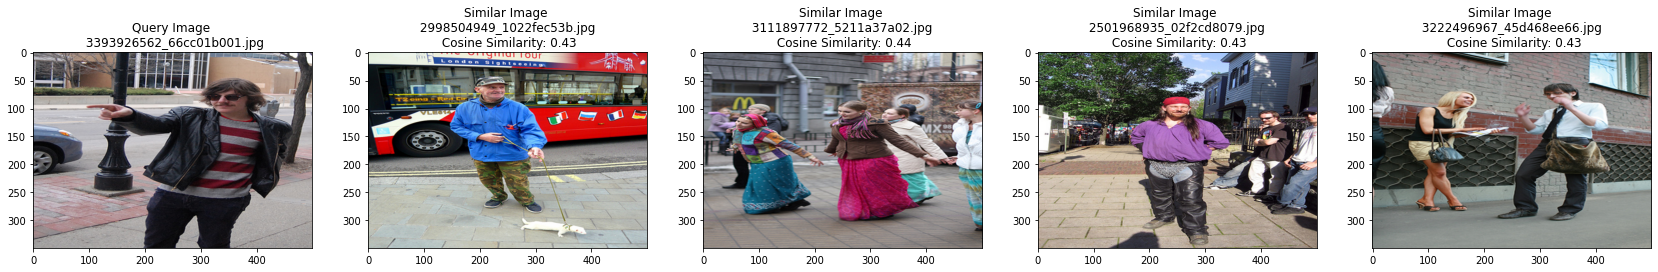

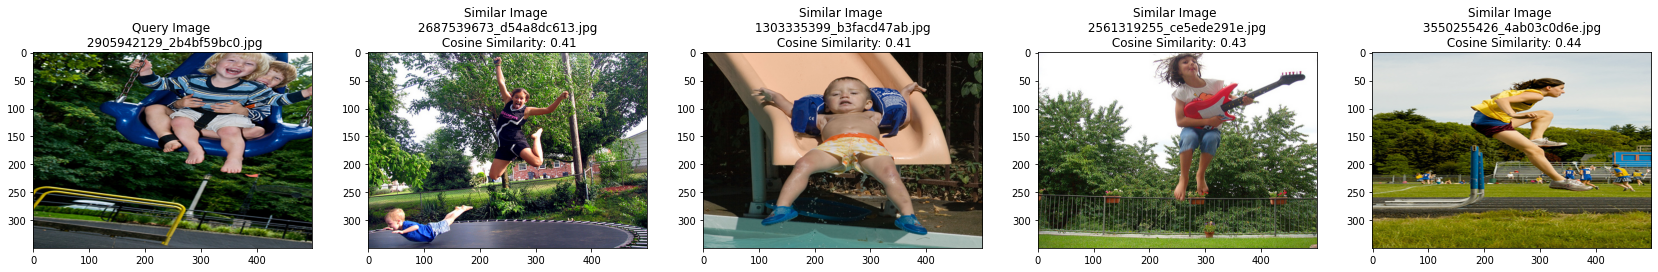

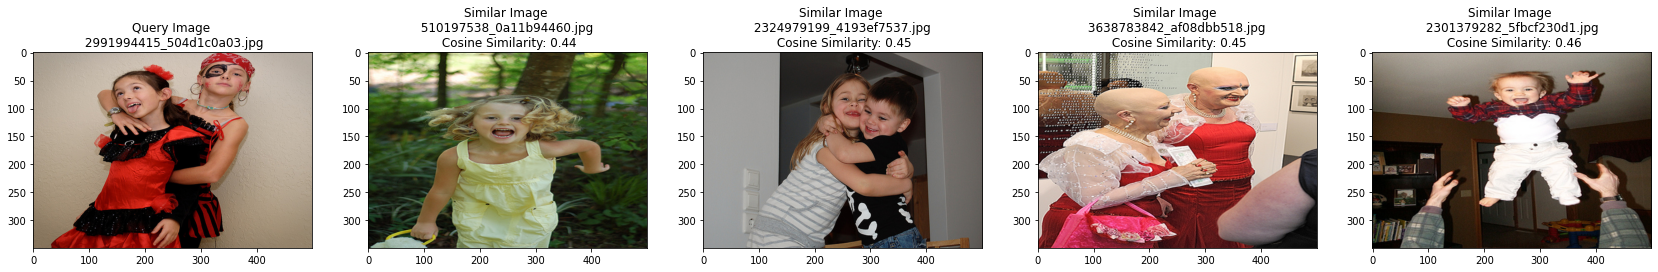

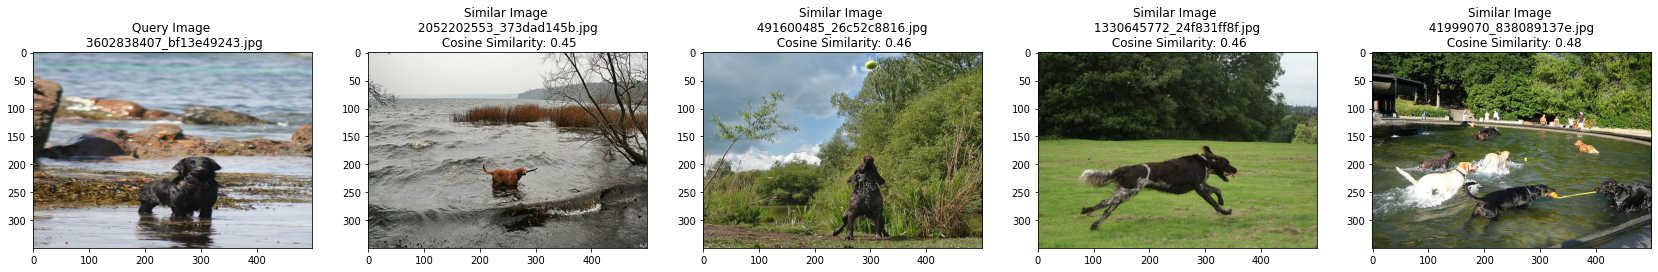

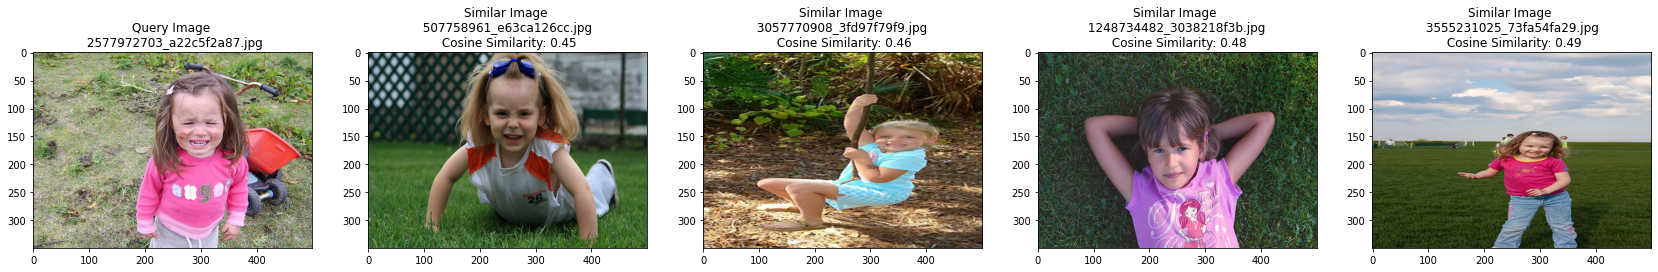

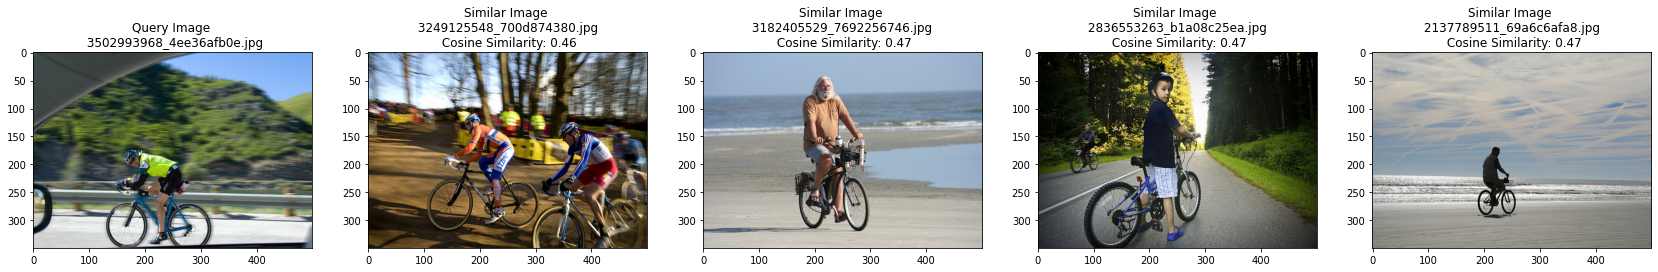

In [ ]:
neighbors = nearest_neighbors(scores, K)
np.random.seed(15)

for i in range(6):
  image_idx = np.random.randint(0, len(test_imgs))
  neighbors_idx = neighbors[image_idx].tolist()
  plot_images(image_idx, neighbors_idx, scores)


In [ ]:
# Below was included in old code
# N = len(input_tensors)
# C, H, W = input_tensors[0].shape
# print(N, C, H, W) 

# # Convert list of N tensors into tensor of [N, C, H, W], N is batch size
# input_tensors = torch.stack(input_tensors)
# print(input_tensors.size())
# print(len(image_arr))

In [ ]:
# Feature extraction
# expect input_tensors of size [N, C, H, W]
outputs = model(input_tensors)

print(outputs.data.size())

# Flatten output tensors - [N, F]
outputs = torch.flatten(outputs, start_dim=1)
print(outputs.size())

In [ ]:
# Convert tensors back to numpy for k-NN later
features = outputs.detach().cpu().numpy()

In [ ]:
features.shape

### Transformer

In [ ]:
pip install transformers

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 71.3 MB/s 
     |████████████████████████████████| 77 kB 8.5 MB/s 
     |████████████████████████████████| 6.6 MB 41.5 MB/s 
     |████████████████████████████████| 895 kB 64.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install datasets

     |████████████████████████████████| 325 kB 4.8 MB/s 
     |████████████████████████████████| 212 kB 65.4 MB/s 
     |████████████████████████████████| 1.1 MB 65.3 MB/s 
     |████████████████████████████████| 136 kB 66.4 MB/s 
     |████████████████████████████████| 127 kB 59.2 MB/s 
     |████████████████████████████████| 271 kB 70.6 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 144 kB 48.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import transformers
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

In [ ]:
from datasets import load_dataset

billsum = load_dataset("billsum", split="ca_test")

Using custom data configuration default


Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

Dataset billsum downloaded and prepared to /root/.cache/huggingface/datasets/billsum/default/3.0.0/d1e95173aed3acb71327864be74ead49b578522e4c7206048b2f2e5351b57959. Subsequent calls will reuse this data.


In [ ]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_billsum = billsum.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_billsum["train"],
    eval_dataset=tokenized_billsum["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

KeyError: ignored

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
summarizer = pipeline("summarization")

NameError: ignored

In [ ]:
summarized = summarizer(to_tokenize, min_length=75, max_length=300)

NameError: ignored

In [ ]:
from transformers import pipeline

# using pipeline API for summarization task
summarization = pipeline("summarization")
original_text = """
Paul Walker is hardly the first actor to die during a production. 
But Walker's death in November 2013 at the age of 40 after a car crash was especially eerie given his rise to fame in the "Fast and Furious" film franchise. 
The release of "Furious 7" on Friday offers the opportunity for fans to remember -- and possibly grieve again -- the man that so many have praised as one of the nicest guys in Hollywood. 
"He was a person of humility, integrity, and compassion," military veteran Kyle Upham said in an email to CNN. 
Walker secretly paid for the engagement ring Upham shopped for with his bride. 
"We didn't know him personally but this was apparent in the short time we spent with him. 
I know that we will never forget him and he will always be someone very special to us," said Upham. 
The actor was on break from filming "Furious 7" at the time of the fiery accident, which also claimed the life of the car's driver, Roger Rodas. 
Producers said early on that they would not kill off Walker's character, Brian O'Connor, a former cop turned road racer. Instead, the script was rewritten and special effects were used to finish scenes, with Walker's brothers, Cody and Caleb, serving as body doubles. 
There are scenes that will resonate with the audience -- including the ending, in which the filmmakers figured out a touching way to pay tribute to Walker while "retiring" his character. At the premiere Wednesday night in Hollywood, Walker's co-star and close friend Vin Diesel gave a tearful speech before the screening, saying "This movie is more than a movie." "You'll feel it when you see it," Diesel said. "There's something emotional that happens to you, where you walk out of this movie and you appreciate everyone you love because you just never know when the last day is you're gonna see them." There have been multiple tributes to Walker leading up to the release. Diesel revealed in an interview with the "Today" show that he had named his newborn daughter after Walker. 
Social media has also been paying homage to the late actor. A week after Walker's death, about 5,000 people attended an outdoor memorial to him in Los Angeles. Most had never met him. Marcus Coleman told CNN he spent almost $1,000 to truck in a banner from Bakersfield for people to sign at the memorial. "It's like losing a friend or a really close family member ... even though he is an actor and we never really met face to face," Coleman said. "Sitting there, bringing his movies into your house or watching on TV, it's like getting to know somebody. It really, really hurts." Walker's younger brother Cody told People magazine that he was initially nervous about how "Furious 7" would turn out, but he is happy with the film. "It's bittersweet, but I think Paul would be proud," he said. CNN's Paul Vercammen contributed to this report.
"""
summary_text = summarization(original_text)[0]['summary_text']
print("Summary:", summary_text)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Summary:  Paul Walker died in November 2013 after a car crash in Los Angeles . The late actor was one of the nicest guys in Hollywood . The release of "Furious 7" on Friday offers a chance to grieve again . There have been multiple tributes to Walker leading up to the film's release .


In [ ]:
summarizer = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")
summarizer("An apple a day, keeps the doctor away", min_length=5, max_length=20)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Your max_length is set to 20, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


[{'summary_text': 'an apple a day, keeps the doctor away from the doctor .'}]

In [ ]:
summarizer("A priority queue is commonly represented using the data structure ‘heap.’ The heapq module in the Python standard library can be used to carry out this implementation. The functions of the heapq module serve the goal of choosing the best element. In Python, the heap data structure has the feature of always popping the smallest heap member (min-heap). The heap structure is preserved whenever data pieces are popped or pushed.",min_length=10, max_length=20)

[{'summary_text': 'the heapq module in the Python standard library can be used to carry out this implementation .'}]

In [ ]:
original_text = """India, officially the Republic of India (Hindi: Bhārat Gaṇarājya),[26] is a country in South Asia. It is the seventh-largest country by area, the second-most populous country, and the most populous democracy in the world. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west;[f] China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is in the vicinity of Sri Lanka and the Maldives; its Andaman and Nicobar Islands share a maritime border with Thailand, Myanmar and Indonesia.

Modern humans arrived on the Indian subcontinent from Africa no later than 55,000 years ago.[27][28][29] Their long occupation, initially in varying forms of isolation as hunter-gatherers, has made the region highly diverse, second only to Africa in human genetic diversity.[30] Settled life emerged on the subcontinent in the western margins of the Indus river basin 9,000 years ago, evolving gradually into the Indus Valley Civilisation of the third millennium BCE.[31] By 1200 BCE, an archaic form of Sanskrit, an Indo-European language, had diffused into India from the northwest,[32][33] unfolding as the language of the Rigveda, and recording the dawning of Hinduism in India.[34] The Dravidian languages of India were supplanted in the northern and western regions.[35] By 400 BCE, stratification and exclusion by caste had emerged within Hinduism,[36] and Buddhism and Jainism had arisen, proclaiming social orders unlinked to heredity.[37] Early political consolidations gave rise to the loose-knit Maurya and Gupta Empires based in the Ganges Basin.[38] Their collective era was suffused with wide-ranging creativity,[39] but also marked by the declining status of women,[40] and the incorporation of untouchability into an organised system of belief.[g][41] In South India, the Middle kingdoms exported Dravidian-languages scripts and religious cultures to the kingdoms of Southeast Asia.[42]

In the early medieval era, Christianity, Islam, Judaism, and Zoroastrianism put down roots on India's southern and western coasts.[43] Muslim armies from Central Asia intermittently overran India's northern plains,[44] eventually establishing the Delhi Sultanate, and drawing northern India into the cosmopolitan networks of medieval Islam.[45] In the 15th century, the Vijayanagara Empire created a long-lasting composite Hindu culture in south India.[46] In the Punjab, Sikhism emerged, rejecting institutionalised religion.[47] The Mughal Empire, in 1526, ushered in two centuries of relative peace,[48] leaving a legacy of luminous architecture.[h][49] Gradually expanding rule of the British East India Company followed, turning India into a colonial economy, but also consolidating its sovereignty.[50] British Crown rule began in 1858. The rights promised to Indians were granted slowly,[51][52] but technological changes were introduced, and ideas of education, modernity and the public life took root.[53] A pioneering and influential nationalist movement emerged, which was noted for nonviolent resistance and became the major factor in ending British rule.[54] In 1947 the British Indian Empire was partitioned into two independent dominions, a Hindu-majority Dominion of India and a Muslim-majority Dominion of Pakistan, amid large-scale loss of life and an unprecedented migration. """

In [ ]:
summary_text = summarization(original_text)[0]['summary_text']
print("Summary:", summary_text)

Summary:  India, officially the Republic of India (Hindi: Bhārat Gaṇarājya), is a country in South Asia . It is the seventh-largest country by area, the second-most populous country, and the most populous democracy in the world . Modern humans arrived on the Indian subcontinent from Africa no later than 55,000 years ago .
